Introduction

Twitter has become a valuable source of real-time information during emergencies and disasters. However, not all tweets that mention disaster-related keywords are actually about real disasters. Some may use such terms metaphorically or in a non-disaster context. The goal of this project is to build a machine learning model that can distinguish between tweets about real disasters and those that are not.

Objective

Develop a predictive model that can identify which tweets are about real disasters and which ones are not, using natural language processing (NLP) techniques.

Evaluation Metric

Submissions are evaluated using the F1 Score, which considers both precision and recall of the classification model.

Submission Format

For each tweet in the test set, we need to predict a target value:

1 if the tweet is about a real disaster.
0 if the tweet is not about a real disaster.

Açelya Deniz Güngördü

In [70]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.3 MB/s eta 0:00:00


# Preprocessing

In [58]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [59]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

The purpose of the clean_text function is to prepare raw text data for further analysis or modeling by removing noise and standardizing the text. This is a common step in natural language processing (NLP) tasks.

By applying these transformations, the clean_text function prepares the text data for further processing, such as tokenization, vectorization, or input into machine learning models. This cleaning step is crucial to ensure that the text data is in a consistent and noise-free format, which can improve the performance of NLP models.

In [ ]:
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

In [61]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(words)
    return text

The preprocess_text function is designed to further process text data by tokenizing it, removing stopwords, and lemmatizing the words. This is a common step in natural language processing (NLP) to prepare text for analysis or modeling. The preprocess_text function plays a crucial role in preparing textual data for analysis:

Enhances Model Performance: By standardizing and cleaning the text, models can learn from relevant patterns without noise.
Reduces Dimensionality: Removing stopwords and normalizing words reduces the feature space, making models more efficient.
Improves Generalization: Helps models generalize better to unseen data by focusing on essential words.
Understanding each step in the preprocessing pipeline allows you to make informed decisions about what techniques to apply based on your specific NLP task.

In [62]:
train_df['processed_text'] = train_df['clean_text'].apply(preprocess_text)
test_df['processed_text'] = test_df['clean_text'].apply(preprocess_text)

In [63]:
train_df['keyword'].fillna('no_keyword', inplace=True)
test_df['keyword'].fillna('no_keyword', inplace=True)

In [64]:
train_df['combined_text'] = train_df['keyword'] + ' ' + train_df['processed_text']
test_df['combined_text'] = test_df['keyword'] + ' ' + test_df['processed_text']

In [81]:
X = train_df['processed_text']
y = train_df['target']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

model_performances = {}

def train_evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    """
    Train and evaluate a model, storing its performance metrics
    """
    start_time = time.time()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    f1 = f1_score(y_val, y_pred)

    training_time = time.time() - start_time

    model_performances[model_name] = {
        'f1_score': f1,
        'training_time': training_time,
        'model': model
    }

    print(f"\n{model_name} Results:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    return model




X: Contains the processed text data (features)

y: Contains the binary target labels (0: not disaster, 1: disaster)

train_test_split:
Splits data into training (80%) and validation (20%) sets
random_state=42: Ensures reproducible splits
stratify=y: Maintains the same proportion of samples for each class

TfidfVectorizer:
Converts text to numerical features using TF-IDF
max_features=5000: Keeps only the top 5000 most frequent terms
ngram_range=(1, 2): Creates features from:
Single words (unigrams)
Two-word combinations (bigrams)
fit_transform: Learns vocabulary from training data and transforms it
transform: Applies learned vocabulary to validation data

# Train and evaluate different models

Training Logistic Regression...

Logistic Regression Results:
F1 Score: 0.7727
Training Time: 0.04 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.85      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523


Training Naive Bayes...

Naive Bayes Results:
F1 Score: 0.7539
Training Time: 0.01 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       869
           1       0.87      0.67      0.75       654

    accuracy                           0.81      1523
   macro avg       0.83      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523


Training Linear SVM...

Linear SVM Results:
F1 Score: 0.7595
Training Time: 0.02 seconds

Classifi

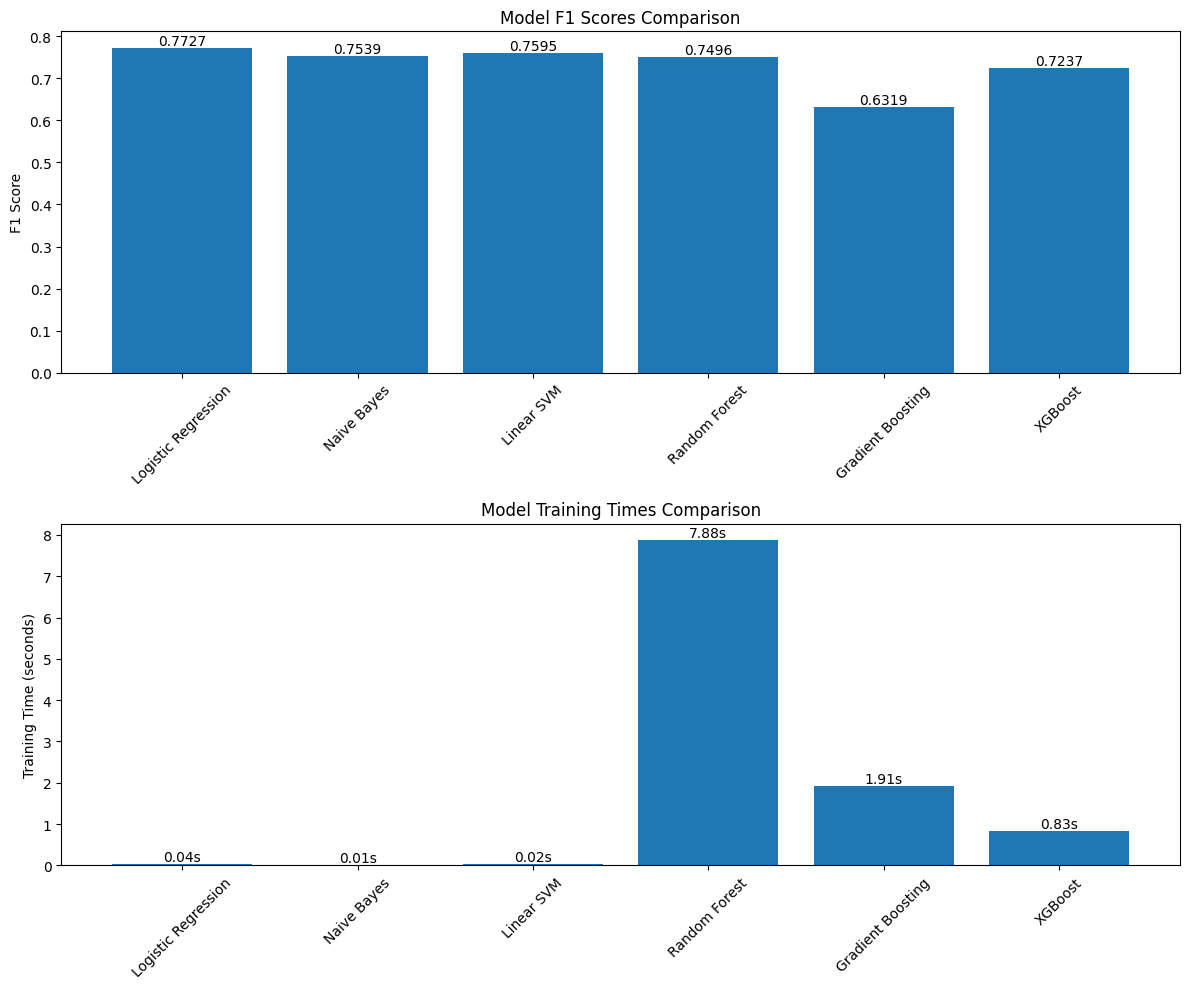


Best Model: Logistic Regression
Best F1 Score: 0.7727


In [82]:


print("Training Logistic Regression...")
lr_model = train_evaluate_model(
    LogisticRegression(max_iter=1000, random_state=42),
    X_train_tfidf, X_val_tfidf, y_train, y_val,
    "Logistic Regression"
)

# 2. Multinomial Naive Bayes
print("\nTraining Naive Bayes...")
nb_model = train_evaluate_model(
    MultinomialNB(),
    X_train_tfidf, X_val_tfidf, y_train, y_val,
    "Naive Bayes"
)

# 3. Linear SVM
print("\nTraining Linear SVM...")
svm_model = train_evaluate_model(
    LinearSVC(random_state=42, max_iter=1000),
    X_train_tfidf, X_val_tfidf, y_train, y_val,
    "Linear SVM"
)

# 4. Random Forest
print("\nTraining Random Forest...")
rf_model = train_evaluate_model(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train_tfidf, X_val_tfidf, y_train, y_val,
    "Random Forest"
)

# 5. Gradient Boosting
print("\nTraining Gradient Boosting...")
gb_model = train_evaluate_model(
    GradientBoostingClassifier(n_estimators=100, random_state=42),
    X_train_tfidf, X_val_tfidf, y_train, y_val,
    "Gradient Boosting"
)

# 6. XGBoost
print("\nTraining XGBoost...")
xgb_model = train_evaluate_model(
    XGBClassifier(random_state=42, use_label_encoder=False),
    X_train_tfidf, X_val_tfidf, y_train, y_val,
    "XGBoost"
)

def plot_model_comparison():
    """
    Plot model performances comparison
    """
    models = list(model_performances.keys())
    f1_scores = [model_performances[model]['f1_score'] for model in models]
    training_times = [model_performances[model]['training_time'] for model in models]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    bars1 = ax1.bar(models, f1_scores)
    ax1.set_title('Model F1 Scores Comparison')
    ax1.set_ylabel('F1 Score')
    ax1.tick_params(axis='x', rotation=45)

    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')

    bars2 = ax2.bar(models, training_times)
    ax2.set_title('Model Training Times Comparison')
    ax2.set_ylabel('Training Time (seconds)')
    ax2.tick_params(axis='x', rotation=45)

    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}s',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


plot_model_comparison()

best_model_name = max(model_performances.items(),
                     key=lambda x: x[1]['f1_score'])[0]
best_model = model_performances[best_model_name]['model']
best_f1 = model_performances[best_model_name]['f1_score']

print(f"\nBest Model: {best_model_name}")
print(f"Best F1 Score: {best_f1:.4f}")



#Key Observations:

Best Performing Model: Logistic Regression provides the best trade-off between precision and recall for the disaster class, with the highest F1 score and fast training time.
Precision vs. Recall:
High Precision but Lower Recall: Models like Naive Bayes and Gradient Boosting have high precision but lower recall, meaning they are better at avoiding false positives but miss more actual disaster tweets.
Balanced Precision and Recall: Linear SVM strikes a balance, resulting in consistent performance.
Training Time Considerations:
Quick Models: Naive Bayes and Logistic Regression are quick to train, beneficial for iterative development.
Resource-Intensive Models: Random Forest has a significantly longer training time without substantial performance benefits.

Conclusion:

The evaluation indicates that Logistic Regression is the most effective model for classifying disaster-related tweets in this context. It offers the highest F1 score, indicating a good balance between precision and recall, and trains quickly. For practical deployment and further development, focusing on Logistic Regression and fine-tuning it is the recommended approach.

Next Steps:

Hyperparameter Optimization: Use techniques like Grid Search or Randomized Search to find optimal parameters for Logistic Regression.
Model Ensemble: Explore combining predictions from Logistic Regression and Linear SVM to potentially improve performance.
Cross-Validation: Implement k-fold cross-validation to ensure the model's robustness across different data splits.
Model Interpretability: Analyze feature importances to understand which words or n-grams contribute most to predictions, aiding in explainability.

In [1]:
def tune_best_model(best_model_name, best_model):
    """
    Perform hyperparameter tuning for the best model
    """
    from sklearn.model_selection import GridSearchCV

    param_grid = {}

    if best_model_name == "Logistic Regression":
        param_grid = {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }
    elif best_model_name == "Linear SVM":
        param_grid = {
            'C': [0.1, 1, 10],
            'loss': ['hinge', 'squared_hinge']
        }
    elif best_model_name == "Random Forest":
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    elif best_model_name == "Gradient Boosting":
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    elif best_model_name == "XGBoost":
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1]
        }

    if param_grid:
        print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
        grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train_tfidf, y_train)

        print("Best parameters:", grid_search.best_params_)

        y_pred_tuned = grid_search.predict(X_val_tfidf)
        f1_tuned = f1_score(y_val, y_pred_tuned)
        print(f"Tuned model F1 Score: {f1_tuned:.4f}")

        return grid_search.best_estimator_

    return best_model



The function tune_best_model is designed to perform hyperparameter tuning for a given machine learning model using GridSearchCV. Hyperparameter tuning is a crucial step in optimizing model performance by searching for the best combination of parameters that improve the model's predictive accuracy.

In [86]:

best_model_tuned = tune_best_model(best_model_name, best_model)

def make_final_prediction(best_model_tuned):
    """
    Make final predictions using the tuned best model
    """

    X_test_tfidf = tfidf.transform(test_df['processed_text'])

    test_predictions = best_model_tuned.predict(X_test_tfidf)

    submission = pd.DataFrame({
        'id': test_df['id'],
        'target': test_predictions
    })

    submission_filename = f'submission_{best_model_name.lower().replace(" ", "_")}.csv'
    submission.to_csv(submission_filename, index=False)
    print(f"\nSubmission file created: {submission_filename}")

make_final_prediction(best_model_tuned)




Performing hyperparameter tuning for Logistic Regression...
Best parameters: {'C': 1, 'solver': 'lbfgs'}
Tuned model F1 Score: 0.7727

Submission file created: submission_logistic_regression.csv


In [85]:
print("\nModel Selection Summary:")
print("-" * 50)
print(f"Best Model: {best_model_name}")
print(f"Initial F1 Score: {best_f1:.4f}")
print("Hyperparameter tuning completed")
print("Final submission file created")
print("-" * 50)


Model Selection Summary:
--------------------------------------------------
Best Model: Logistic Regression
Initial F1 Score: 0.7727
Hyperparameter tuning completed
Final submission file created
--------------------------------------------------
